# Geometry tutorial: part 2

In the [**first part**](./01_Geometry_part_1) of the `Geometry` tutorial you found out methods and properties which help to **examine geology**.

This notebook is the second part of the `Geometry` tutorial which shows methods that help to **work with seismic data**, specifically:

* [Optimizing seismic data loading](#formats)
* [Saving processed data](#saving)

In [1]:
# All the necessary imports
import os
import sys

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from time import perf_counter
from matplotlib import pyplot as plt

sys.path.insert(0, '../..')
sys.path.insert(0, '..')
from seismiqb import Geometry, plot

In [2]:
%%time
geometry_sgy = Geometry.new(path='/data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.sgy',
                            collect_stats=True, recollect_stats=True)

print(geometry_sgy)

Processed geometry for cube        /data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.sgy
Index headers:                     ['INLINE_3D', 'CROSSLINE_3D']
Traces:                            3_611_267
Shape:                             (2563, 1409, 1501)
Time delay:                        50 ms
Sample rate:                       2.0 ms
Area:                              1522.4 km²

File size:                         21.000 GB
Instance (memory) size:            0.141 GB

Number of dead  traces:            1_175_447
Number of alive traces:            2_435_820
Fullness:                          0.67

Value statistics:
mean | std:                              0.03 | 1887.17   
min | max:                          -47429.45 | 39240.19  
q01 | q99:                           -5459.50 | 5118.29   
Number of unique values:                  214
CPU times: user 1min 38s, sys: 10.9 s, total: 1min 49s
Wall time: 19.4 s


<a id='formats'></a>
# Optimizing seismic data loading

**SEG-Y** format is, essentially, a 2D container of traces. That is not very efficient for slide loading, and we can reshape and rewrite this array into an actual 3D cube of values. As we keep the meta information about the cube right next to it in a `CUBE_NAME.meta` file, so all of the optimized storages need only to keep the array itself.

***By default, a cube in another format is stored right next to its SEG-Y counterpart.***

***Creating a 3D volume requires a strict and clear spatial structure, so converting is restricted to `INLINE_3D`/`CROSSLINE_3D` indexing headers.***

As alternatives to the **SEG-Y** format, we have **HDF5**, **QHDF5**, and **QSGY** formats:

 * [**HDF5**](https://www.hdfgroup.org/solutions/hdf5/) is a scientific format designed to store and organize large amounts of data
 * **QHDF5** is quantized version of **HDF5**, that stores int8 values instead of float32. Quantization process is based on cube statistics, but still loses some accuracy
 * **QSGY** stores int8 values in accordance to SEG-Y standard

Let's compare data formats from a speed and storage efficiency points of view:

In [3]:
%%time
converted_path = geometry_sgy.repack_segy()
geometry_qsgy = Geometry.new(converted_path)

100%|██████████████████████████████| 3611267/3611267 [00:40<00:00, 88215.53it/s]
CPU times: user 1min 27s, sys: 5.74 s, total: 1min 32s
Wall time: 1min 5s


In [4]:
%%time
geometry_hdf5 = geometry_sgy.convert('hdf5')

Converting to 001_YETYPUR.hdf5:d: 100%|███████████████████████████████████| 5473/5473 [25:38<00:00,  3.56it/s]
CPU times: user 25min 32s, sys: 11 s, total: 25min 43s
Wall time: 25min 40s


In [5]:
%%time
geometry_qhdf5 = geometry_sgy.convert('qhdf5')

Converting to 001_YETYPUR.qhdf5:d: 100%|██████████████████████████████████| 5473/5473 [17:29<00:00,  5.22it/s]
CPU times: user 17min 21s, sys: 21.8 s, total: 17min 43s
Wall time: 17min 40s


In [6]:
names = ["SEG-Y", "QSEG-Y", "HDF5", "QHDF5"]
geometries = [geometry_sgy, geometry_qsgy, geometry_hdf5, geometry_qhdf5]

In [7]:
timings = {}
sizes = {}

for geometry, name in zip(geometries, names):
    timings[name] = geometry.benchmark(slide_allowed_axis=(0, 1))
    sizes[name] = os.path.getsize(geometry.path) / (1024**3)

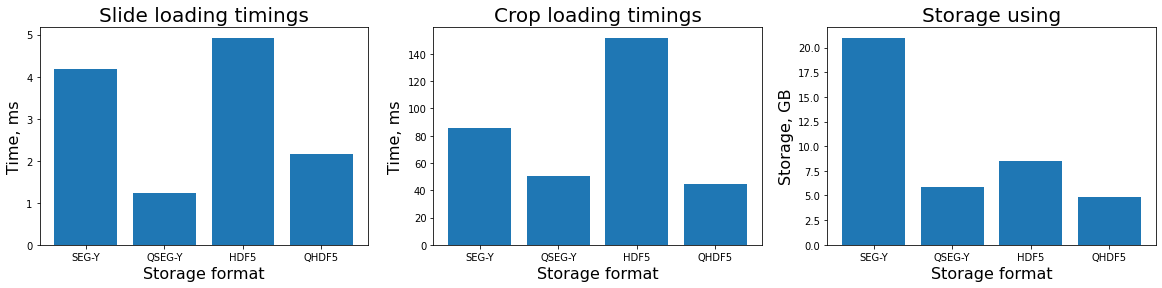

In [8]:
def plot_ax(dct, unit, title, ax):
    bars = ax.bar(dct.keys(), dct.values())
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Storage format', fontsize=16)
    ax.set_ylabel(unit, fontsize=16)
    return ax

fig, axs = plt.subplots(1, 3, figsize=(20, 4))
axs[0] = plot_ax({key: value['slide']['wall'] for key, value in timings.items()},
                 "Time, ms", "Slide loading timings", axs[0])
axs[1] = plot_ax({key: value['crop']['wall'] for key, value in timings.items()},
                 "Time, ms", "Crop loading timings", axs[1])
axs[2] = plot_ax(sizes, "Storage, GB", "Storage using", axs[2])

plt.show()

Note the bigger cube size in **HDF5** format: it is almost 3 times the size of the original **SEG-Y** cube! That is because we store not only the `(iline, crossline, depth)` projection but also the `(crossline, depth, iline)` and `(depth, iline, crossline)` ones: that is done to make slide loading along all the dimensions as fast as possible. As we can see, the converted version is much faster.

So we have that:
 * **QBLOSC** is more efficient in terms of data storage;
 * **QHDF5** provides the best load data timings.

***The entire functionality is the same for all formats:***

Straightforward quality estimation of the seismic data can be done by looking at the signal-to-noise ratio for each of the traces: in our case, it is defined as:
$$ log_{10} \frac{E(trace)^2}{Var(trace)^2}$$

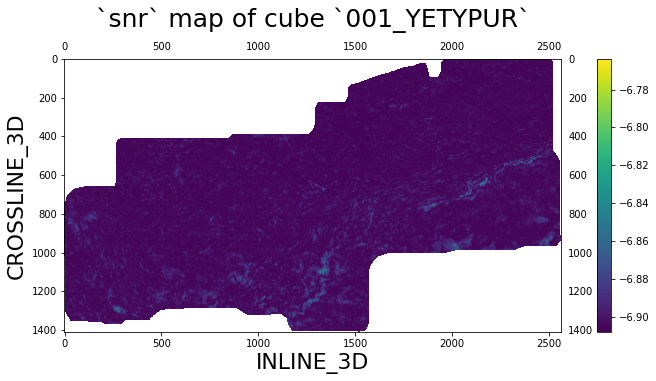

In [9]:
geometry_qhdf5.show(matrix='snr', cmap='viridis')

Obviously, all of the previous visualization functions are still available.

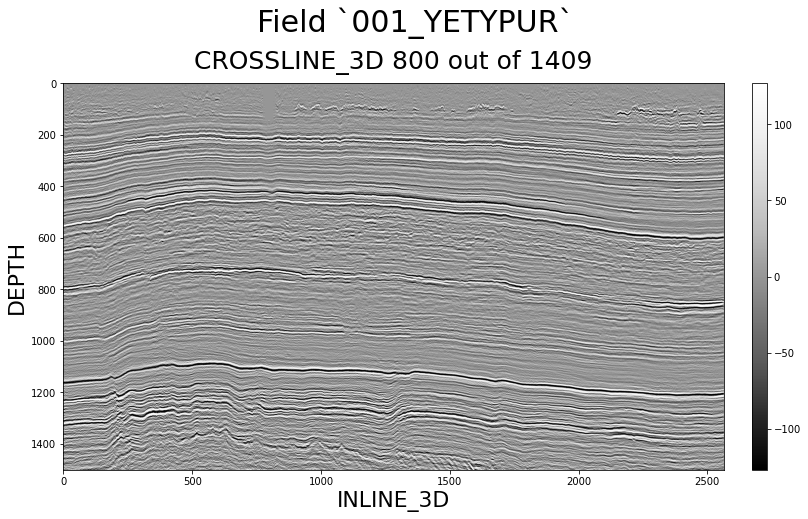

In [10]:
geometry.show_slide(index=800, axis=1, figsize=(12, 6))

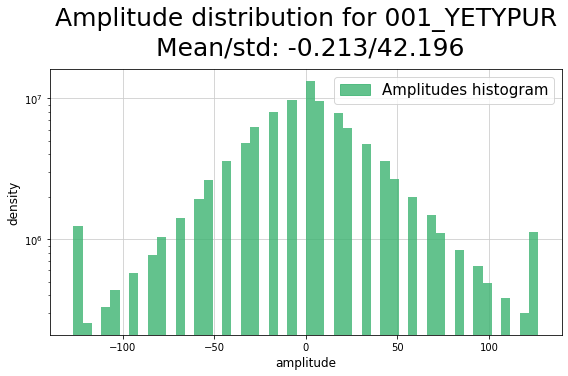

In [11]:
geometry_qhdf5.show_histogram(histogram_log=True)

<a id='saving'></a>
# Saving processed data

When all work with a cube is done, we can easily save results.
For example, we have an array with a processed cube and want to dump it into memory as a new **SEG-Y** cube:

In [12]:
from seismiqb import array_to_segy
!rm processed.*

In [13]:
%%time
processed_data = geometry[1000:2000, 500:1000, :] * 2
processed_data = processed_data.copy()

array_to_segy(array_like=processed_data, sample_rate=2.0, delay=50,
              path='processed.sgy', zip_segy=False)

Array to SEG-Y: 100%|██████████████████████| 1000/1000 [00:02<00:00, 449.87it/s]
CPU times: user 2.47 s, sys: 9.2 s, total: 11.7 s
Wall time: 5.66 s


Let's check processed cube:

In [14]:
geometry_processed_sgy = Geometry.new(path='processed.sgy', collect_stats=False, pbar='t')
print(f"Cubes have same values: {np.all(geometry_processed_sgy[:, :, :].ravel()==processed_data.ravel())}")

Cubes have same values: True


# Conclusion

This concludes the `Geometry` tutorial: now you know how to work with various cubes with the help of our framework. To sum up, you have learned how to:

- infer geological properties like SNR of seismic cubes
- load actual slices of seismic data, as well as visualize them
- convert SEGY-cubes into HDF5, BLOSC, QHDF5, QBLOSC-formats for faster data loading
- display simple amplitude distribution statistics
- save processed cubes

The [next tutorial](./01_Horizon.ipynb) shows how to add 2D surfaces, also known as horizons, to the cubes.